# Proyecto


In [ ]:
%load_ext autoreload
%autoreload 3

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

## 1: Importando bibliotecas


In [36]:
import matplotlib.pyplot as plt
from keras import Model, Sequential
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

## 2: Creando nuestros ImageDataGenerators

Para este punto de la clase NO hemos hablado de `Data Augmentation` cosa que si has tomado este repositorio completo entonces ya debes conocer y entender. Ahora lo único que vamos a hacer es utilizar el `ImageDataGenerator` para normalizar las imágenes y esta clase nos permita generar un objeto con el método `frow_from_directory`

Nota: Algo interesante es que del test_dataget también vamos a construir el validation test, por haber definido el parámetro validation_split


In [3]:
train_dir = "../data/rice_dataset/Train"
test_dir = "../data/rice_dataset/Test"
val_dir = "../data/rice_dataset/Validation"

In [4]:
train_datagen = ImageDataGenerator(rescale=1 / 255)
test_datagen = ImageDataGenerator(rescale=1 / 255)
val_datagen = ImageDataGenerator(rescale=1 / 255, validation_split=0.6)

## 3: Creamos nuestros generadores de imágenes, para los conjuntos de train, validation y test


In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training",
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation",
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode="categorical",
    color_mode="grayscale",
)

Found 50000 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.
Found 12500 images belonging to 5 classes.


## 4: Generando el nombre de las clases

Sabemos que las clases están en label_encoding entonces hace falta definir el nombre de las labels de la siguiente manera


In [6]:
classes = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

print("Classes: ", classes)

Classes:  ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


## 5: Muestra de entrenamiento


Definimos una función auxiliar para mostrar imágenes:


In [7]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:, :, 0], cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

Generamos una muestra de 5 imágenes de nuestro `train_generator`


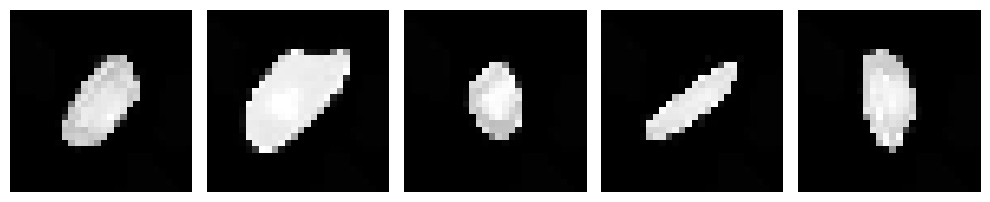

In [8]:
sample_trainnig_images, _ = next(train_generator)
plot_images(sample_trainnig_images[:5])

# Crear la red neuronal, definir capas, compilar, entrenar, evaluar y predicciones

Este será nuestra primera aproximación a resolver el problema de clasificación de aroz


In [9]:
def plot_results(history_, metric):
    history_dict = history_.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    metric_values = history_dict[metric]
    val_metric_values = history_dict[f"val_{metric}"]

    epoch = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    fig.suptitle("Neural Network's Result")
    ax[0].set_title("Loss function over epoch")
    ax[0].set(ylabel="loss", xlabel="epoch")
    ax[0].plot(epoch, loss_values, "go-", label="training")
    ax[0].plot(epoch, val_loss_values, "ro-", label="validation")
    ax[0].legend()

    ax[1].set_title(f"{metric} over epoch")
    ax[1].set(ylabel=metric, xlabel="epochs")
    ax[1].plot(epoch, metric_values, "go-", label="training")
    ax[1].plot(epoch, val_metric_values, "ro-", label="validation")
    ax[1].legend()
    plt.show()

## 6: Crear la arquitectura base del modelo


In [ ]:
def base_architecture(input_shape: tuple, n_clases: int):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(n_clases, activation="softmax"))
    print(model.summary())
    return model

Llamamos a nuestra función auxiliar en nuestro ciclo principal.


In [ ]:
base_model = base_architecture(input_shape=(28, 28, 1), n_clases=len(classes))

## 7: Compilamos el modelo


In [ ]:
base_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
)

Recordemos que como es un problema de clasificación multiple nuestra perdida debe ser: `categorical_crossentropy` y la última capa de clasificación del modelo tendrá 24 neuronas una por cada clase disponible y a su vez esto nos hace necesitar usar `softmax` como función de activación.


## 8: Entrenamos el modelo


In [ ]:
history = base_model.fit(
    train_generator, epochs=10, validation_data=validation_generator, batch_size=64
)

## 9: Análisis de resultados


In [ ]:
plot_results(history, "accuracy")

results = base_model.evaluate(test_generator)

Para resumir, la estructura en código de este ejercicio fue:


Para este momento hemos conseguido un `accuracy` del **97.577%** del modelo


La estructura de código de esta clase se mantiene igual a la de la clase anterior, el único cambio relevante es el cambio de la arquitectura base del modelo por una regularizada:


In [ ]:
def base_architecture_w_regularizes(input_shape, n_clases):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(n_clases, activation="softmax"))
    print(model.summary())
    return model

In [ ]:
regularized_model = base_architecture_w_regularizes(
    input_shape=(28, 28, 1), n_clases=len(classes)
)

In [ ]:
regularized_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
)

In [ ]:
history_regularized = regularized_model.fit(
    train_generator, epochs=10, validation_data=validation_generator, batch_size=64
)

In [ ]:
plot_results(history_regularized, "accuracy")

results_regularized = regularized_model.evaluate(test_generator)

In [10]:
def conv_architecture(input_shape, n_clases):
    model = Sequential()
    model.add(
        Conv2D(
            filters=128, kernel_size=(3, 3), activation="relu", input_shape=input_shape
        )
    )
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(n_clases, activation="softmax"))
    print(model.summary())
    return model

In [14]:
conv_model = conv_architecture(input_shape=(28, 28, 1), n_clases=len(classes))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 128)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 256)               5538048   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                      

In [15]:
conv_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
)

In [ ]:
history_conv = conv_model.fit(
    train_generator, epochs=10, validation_data=validation_generator, batch_size=64
)

In [ ]:
plot_results(history_conv, "accuracy")

results_conv = conv_model.evaluate(test_generator)

## Métricas para medir la eficiencia de un modelo: Callback


En este ejemplo vamos a definir un pequeño `Custom Callback`

Supongamos que queremos detener el proceso de entrenamiento del modelo cuando el mismo haya logrado alcanzar al menos 80% de accuracy en el set de validación.

Lo único que necesitamos hacer es crear una clase que contenga nuestra `CustoCallback`:


In [11]:
class TrainingCallback(Callback):

    def __init__(self, acc_stop):
        super().__init__()
        self.acc_stop = acc_stop

    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy") > self.acc_stop:
            print(f"Lo hemos logrado! El modelo ha llegado a un {self.acc_stop * 100}%")
            self.model.stop_training = True

Existen varios overrides que podemos hacer para crear nuestras Callbacks propias, entre ellas podemos encontrar las siguientes:


In [ ]:
from keras.callbacks import Callback


class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training....")

    def on_epoch_begin(self, epoch, logs=None):
        print("Starting epoch {}".format(epoch))

    def on_train_batch_begin(self, batch, logs=None):
        print("Training: Starting batch {}".format(batch))

    def on_train_batch_end(self, batch, logs=None):
        print("Training: Finished batch {}".format(batch))

    def on_epoch_end(self, epoch, logs=None):
        print("Finished epoch {}".format(epoch))

    def on_train_end(self, logs=None):
        print("Finished training!")


class TestingCallback(Callback):
    def on_test_begin(self, logs=None):
        print("Starting testing....")

    def on_test_batch_begin(self, batch, logs=None):
        print("Testing: Starting batch {}".format(batch))

    def on_test_batch_end(self, batch, logs=None):
        print("Testing: Finished batch {}".format(batch))

    def on_test_end(self, logs=None):
        print("Finished testing!")


class PredictionCallback(Callback):
    def on_predict_begin(self, logs=None):
        print("Prediction testing....")

    def on_predict_batch_begin(self, batch, logs=None):
        print("Prediction: Starting batch {}".format(batch))

    def on_predict_batch_end(self, batch, logs=None):
        print("Prediction: Finished batch {}".format(batch))

    def on_predict_end(self, logs=None):
        print("Finished prediction!")

In [20]:
callback_my = TrainingCallback(acc_stop=0.95)

In [21]:
history_conv = conv_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    batch_size=64,
    callbacks=[callback_my],
)

Epoch 1/20
782/782 [==============================] - 45s 58ms/step - loss: 0.1178 - accuracy: 0.9642 - val_loss: 0.1056 - val_accuracy: 0.9693


Aquí el proceso se ha detenido a pesar de que le hemos pedido que hiciera 10 epochs esto muestra como hemos hecho funcionar correctamente nuestra propuesta de EarlyStop basada en el val_accuracy.


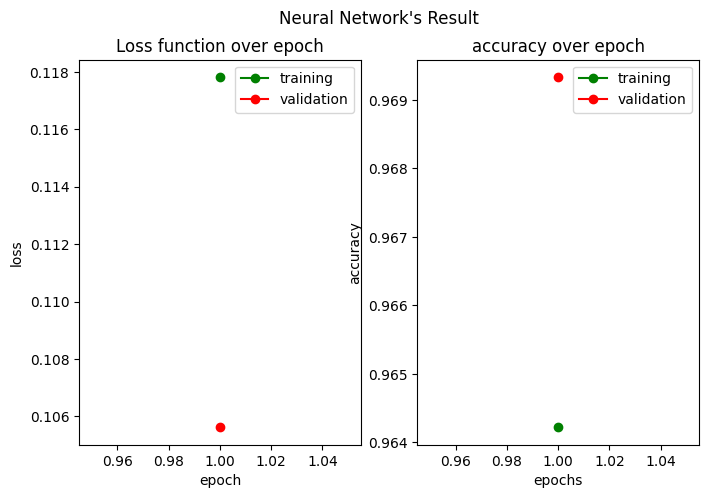

196/196 [==============================] - 4s 22ms/step - loss: 0.0952 - accuracy: 0.9733


In [22]:
plot_results(history_conv, "accuracy")

results_conv = conv_model.evaluate(test_generator)

## Monitoreo del entrenamiento en tiempo real: early stopping y patience


In [24]:
callback_early = EarlyStopping(monitor="val_accuracy", patience=3, mode="auto")

history_conv = conv_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    batch_size=64,
    callbacks=[callback_early],
)

Epoch 1/20
782/782 [==============================] - 45s 58ms/step - loss: 0.1119 - accuracy: 0.9673 - val_loss: 0.1048 - val_accuracy: 0.9707
Epoch 2/20
782/782 [==============================] - 44s 56ms/step - loss: 0.1049 - accuracy: 0.9700 - val_loss: 0.1071 - val_accuracy: 0.9717
Epoch 3/20
782/782 [==============================] - 46s 58ms/step - loss: 0.1009 - accuracy: 0.9723 - val_loss: 0.1156 - val_accuracy: 0.9656
Epoch 4/20
782/782 [==============================] - 45s 57ms/step - loss: 0.0972 - accuracy: 0.9728 - val_loss: 0.1063 - val_accuracy: 0.9709
Epoch 5/20
782/782 [==============================] - 44s 56ms/step - loss: 0.0943 - accuracy: 0.9743 - val_loss: 0.1086 - val_accuracy: 0.9723
Epoch 6/20
782/782 [==============================] - 43s 55ms/step - loss: 0.0894 - accuracy: 0.9766 - val_loss: 0.1023 - val_accuracy: 0.9723
Epoch 7/20
782/782 [==============================] - 43s 55ms/step - loss: 0.0852 - accuracy: 0.9771 - val_loss: 0.1324 - val_accuracy:

El mejor histórico lo alcanzo en la época 3 con un val_accuracy de 0.8568 y como durante 3 épocas NO mejoro este resultado, entonces automáticamente detuvo el proceso de entrenamiento.


### PLUS: guardando el modelo con checkpoints

Crearemos otro callback para guardar el modelo cada que encuentre una época que optimice el parámetro de accuracy. Lo guardaremos en la carpeta models con el nombre de: best_model.keras


In [27]:
checkpoint = ModelCheckpoint(
    filepath="../model/best_model.keras",
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    verbose=1,
    monitor="val_accuracy",
)

In [28]:
history_conv = conv_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    batch_size=64,
    callbacks=[callback_early, checkpoint],
)

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9793
Epoch 1: val_accuracy improved from -inf to 0.97067, saving model to ../model\best_model.keras
782/782 [==============================] - 44s 57ms/step - loss: 0.0788 - accuracy: 0.9793 - val_loss: 0.1087 - val_accuracy: 0.9707
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9806
Epoch 2: val_accuracy improved from 0.97067 to 0.97573, saving model to ../model\best_model.keras
782/782 [==============================] - 43s 55ms/step - loss: 0.0740 - accuracy: 0.9806 - val_loss: 0.0930 - val_accuracy: 0.9757
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9803
Epoch 3: val_accuracy improved from 0.97573 to 0.97600, saving model to ../model\best_model.keras
782/782 [==============================] - 44s 57ms/step - loss: 0.0747 - accuracy: 0.9802 - val_loss: 0.0978 - val_accuracy: 0.9760
Epoch 4/20
781/782 [==

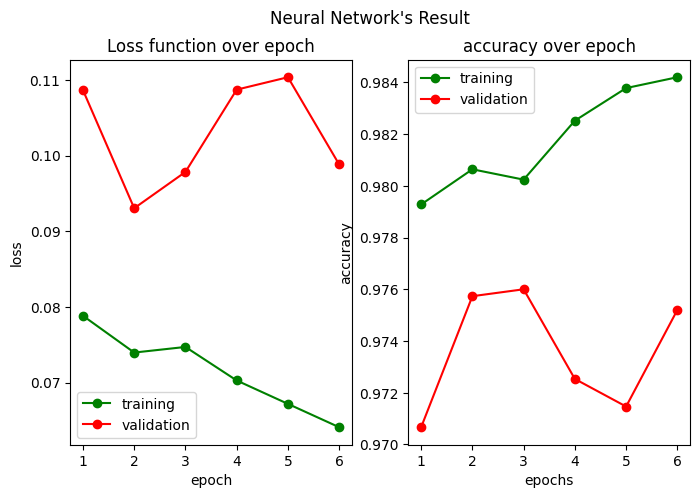

196/196 [==============================] - 4s 20ms/step - loss: 0.0848 - accuracy: 0.9780


In [30]:
plot_results(history_conv, "accuracy")

results_conv = conv_model.evaluate(test_generator)

# kerasTuner: Construyendo el modelo


Sin embargo, en está ocasión vamos a importar nuevas librerías que NO habíamos utilizado antes:


In [10]:
from abc import ABC
from keras_tuner import HyperModel, Hyperband
import json

Nos vamos a enfocar principalmente en `HyperModel` y en `Hyperband` las cuales nos van a permitir construir una clase con la arquitectura del modelo y ciertos parámetros preestablecidos por el constructor de la clase.


## 10: Definiendo la clase de la arquitectura deseada

Por documentación de `keras tuner` para crear nuestra propia clase de `HyperModel` debemos heredar de ella y de ABC definimos nuevos parámetros que en este caso serán: `input_shape` y `n_classes`


In [15]:
class CNNArchitecture(HyperModel, ABC):

    def __init__(self, input_shape, n_classes):
        super().__init__()
        self.input_shape = input_shape
        self.n_classes = n_classes

    def build(self, hp):
        model = Sequential()

        model.add(
            Conv2D(
                filters=128,
                kernel_size=(3, 3),
                activation="relu",
                input_shape=self.input_shape,
            )
        )
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Flatten())

        # Keras-Tuner
        model.add(
            Dense(
                units=hp.Int(
                    "units_1", min_value=64, max_value=512, step=64, default=128
                ),
                activation="relu",
                kernel_regularizer=l2(1e-5),
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    "dropout_1", min_value=0.2, max_value=0.6, default=0.5, step=0.10
                )
            )
        )
        model.add(BatchNormalization())

        model.add(Dense(128, activation="relu", kernel_regularizer=l2(1e-5)))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(self.n_classes, activation="softmax"))

        model.compile(
            Adam(
                hp.Float(
                    "learning_rate",
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling="LOG",
                    default=1e-3,
                )
            ),
            loss="categorical_crossentropy",
            metrics="accuracy",
        )
        # Alternativa a hp.Float -> hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
        return model

De esta forma cuando creemos un objeto de la clase CNNArchitecture podremos definir esos parámetros, los cuáles no se definen por la arquitectura del modelo sino por la naturaleza del problema. En nuestro caso nuestras imágenes del dataset son de `(28x28x1)` y tenemos un total de `24` clases diferenciables.


## 11: Construimos la arquitectura del modelo y compilamos

El parámetro `hp` hace referencia a un diccionario que contenga los valores pre-cargados para los hiperparámetros. Si no se pasa un valor entonces utilizará los parámetros que tenga disponibles para entrenar.

Hasta este momento nuestra arquitectura es idéntica a las que ya hemos venido creado en clases anteriores, con la única diferencia de que ahora al ser un método de una clase accedemos al `input_shape` como `self.input_shape` puesto que este valor lo definimos en el constructor de la clase.

Aquí empieza lo verdaderamente interesante, definir las siguientes capas NO con valores fijos sino con valores que pueden ser variados dentro de un rango predeterminado de valores. Para la siguiente capa que normalmente habiamos definido de la siguiente manera:

```python
  model.add(Dense(256, activation="relu", kernel_regularizer=l2(1e-5)))
  model.add(Dropout(0.2))
```

Podemos hacer que el número de neuronas **256** y el valor de dropout **0.2** No sean constantes si no que sean elegibles dentro de un rango conocido.

```python
model.add(Dense(units=hp.Int("units_1", min_value=64, max_value=512, step=64, default=128),activation="relu", kernel_regularizer=l2(1e-5)))
model.add(Dropout(rate=hp.Float("dropout_1", min_value=0.2, max_value=0.6, default=0.5, step=0.10)))
model.add(BatchNormalization())
```

Lo más interesante es que en lugar de definir `256` neuronas para la capa `Dense` es que estamos proponiendo un rango de **64 a 512** en intervalos de 64, con un valor por defecto de 128. Aquí estamos ocupando el método `Int` pero recordemos que tenemos otros disponibles. Como es el caso de `Float` el cual definimos para el cambiar el rate del dropout.

Continuamos con la arquitectura de nuestro modelo:

```python
model.add(Dense(128, activation="relu", kernel_regularizer=l2(1e-5)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(self.n_classes, activation="softmax"))
```

Hasta aquí nada interesante, son cosas que ya entendemos y conocemos, salvo el hecho de que la última capa la encargada de clasificación está definida por `self.n_classes` variable definida por el constructor de la clase.

Sin embargo, para terminar, debemos compilar el modelo:

```python
model.compile(Adam(hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="LOG", default=1e-3,)),
                      loss="categorical_crossentropy", metrics=['accuracy'])
	# Alternativa a hp.Float -> hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
        return model
```

Nota interesante, que el optimizador `ADAM` también puede verse beneficiado de `keras tuner` puesto que su learning rate ahora no es un solo valor si no que es un rango de valores, puesto que los valores son sumamente pequeños es necesario poner que el `sampling es "LOG"`.


## KerasTuner: Buscando la mejor configuración para tu modelo

Cómo en la clase pasada ya hemos definido la arquitectura del modelo, en esta clase vamos a ver como utilizarla en conjunto al `Hyperband` para hacer nuestra búsqueda de parámetros óptimos para nuestra red:

Empezamos con lo básico: Crear las particiones de nuestros datos


Ahora podemos crear el modelo a partir de nuestra clase `CNNArchitecture`


In [20]:
cnn_model = CNNArchitecture(input_shape=(28, 28, 1), n_classes=len(classes))

Aquí empieza la búsqueda de los mejores hiperparámetros, primero debemos crear un objeto `tuner` de la clase `Hyperband` con nuestro `hypermodel` llamado `cnn_model`:


In [22]:
tuner = Hyperband(
    hypermodel=cnn_model,
    objective="val_accuracy",
    max_epochs=5,
    factor=3,
    directory="../model",
    project_name="Keras_tuner",
)

Te recomiendo leer [Hyperband Tuner](https://keras.io/api/keras_tuner/tuners/hyperband/) para entender más de la documentación de este tuner sin embargo, a continuación te dejo sus parámetros disponibles.


Ahora nuestro objeto `tuner` es un `hypermodel` de `cnn_model` con tuner podemos empezar a hacer la busqueda de los mejores hiperparámetros:


In [23]:
tuner.search(train_generator, epochs=5, validation_data=validation_generator)

Trial 10 Complete [00h 02m 31s]
val_accuracy: 0.9753333330154419

Best val_accuracy So Far: 0.9753333330154419
Total elapsed time: 00h 20m 58s


Ahora nuestro `hypermodel` ya se encuentra entrenado, podemos acceder a los mejores hiperparámetros que encontro:


In [24]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

Esta configuración la podemos usar para construir un modelo:


In [25]:
conv_model = tuner.hypermodel.build(best_hps)

De esta manera `conv_model` ya NO es un `hypermodel` ya es un modelo convencional como los que hemos estado trabajando a lo largo del curso. `conv_model` ya se encuentra tuneado para tener la mejor configuración de hiperparmáetros posible, entonces es buena idea guardar la arquitectura del modelo para reutilizarla después:


In [27]:
config_dict = conv_model.get_config()

print(config_dict)

with open("config_model.json", "w") as outfile:
    json.dump(config_dict, outfile)

{'name': 'sequential_1', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_1_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 28, 28, 1), 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered

Excelente, ahora tenemos un archivo json llamado `config_model.json` el cual ha guarado toda la arquitectura con la mejor configuración posible para nuestro modelo.

Ahora podemos seguir con los conocimientos que ya conocemos para con base en dicha arquitectura y ya con el modelo compilado utilizarlo para entrenarlo desde 0 con nuestro `train_generator` y utilizar `callbacks` para monitorear el mismo:


In [30]:
callback = EarlyStopping(monitor="val_accuracy", patience=3, mode="auto")

checkpoint = ModelCheckpoint(
    filepath="../model/best_model_hyper.keras",
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    verbose=1,
    monitor="val_accuracy",
)

history = conv_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    batch_size=64,
    callbacks=[callback, checkpoint],
)

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9201
Epoch 1: val_accuracy improved from -inf to 0.96160, saving model to ../model\best_model_hyper.keras
391/391 [==============================] - 31s 77ms/step - loss: 0.2287 - accuracy: 0.9201 - val_loss: 0.1196 - val_accuracy: 0.9616
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9599
Epoch 2: val_accuracy improved from 0.96160 to 0.96960, saving model to ../model\best_model_hyper.keras
391/391 [==============================] - 29s 75ms/step - loss: 0.1225 - accuracy: 0.9599 - val_loss: 0.0952 - val_accuracy: 0.9696
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9668
Epoch 3: val_accuracy did not improve from 0.96960
391/391 [==============================] - 29s 74ms/step - loss: 0.1028 - accuracy: 0.9668 - val_loss: 0.1081 - val_accuracy: 0.9660
Epoch 4/10
391/391 [==============================] - ETA

Graficamos los resultados y evaluamos en el `test_generator`


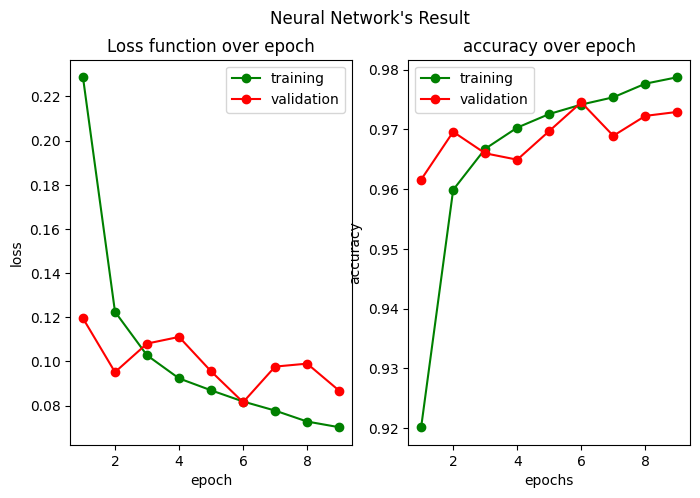

98/98 [==============================] - 7s 72ms/step - loss: 0.0687 - accuracy: 0.9799


In [31]:
plot_results(history, "accuracy")

results = conv_model.evaluate(test_generator)

# Almacenamiento y carga de modelos: pesos y arquitectura


Estas serán usadas para guardar la arquitectura del modelo y cargar apropiadamente el modelo.

Ahora podemos definir sencillamente la arquitectura del modelo:


In [11]:
def conv_architecture(input_shape, n_clases):
    model = Sequential()
    model.add(
        Conv2D(
            filters=128, kernel_size=(3, 3), activation="relu", input_shape=input_shape
        )
    )
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(n_clases, activation="softmax"))
    print(model.summary())
    return model

Y aquí viene la parte interesante, vamos a crear una función para generar los archivos de `arquitectura` y `pesos` del modelo:


In [12]:
def generate_weights(
    classes, batch_size, train_generator, validation_generator, test_generator
):
    conv_model = conv_architecture(input_shape=(28, 28, 1), n_clases=len(classes))

    config_dict = conv_model.get_config()

    with open("../model/config_model.json", "w") as outfile:
        json.dump(config_dict, outfile)

    conv_model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
    )

    conv_model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        batch_size=batch_size,
    )

    conv_model.evaluate(test_generator)

    conv_model.save_weights("../model/onlyweights.keras")

Una vez creado el conv_model desde la función conv_architecture podemos acceder a su configuración con el método get_config() esto nos regresa un diccionario con la configuración del modelo el cual podemos guardar en formato json, en este caso con el nombre de config_model.json. Después debemos compilar el modelo y ponerlo a entrenar como siempre lo hemos hecho. Finalmente podemos evaluar el rendimiento del modelo y salvar los pesos con el método save_weights(weights_name.h5)


Ahora podemos crear una función que cargue los pesos y la arquitectura del modelo:


In [13]:
def load_model_from_architecture_and_weights(architecture, weights) -> Model:
    json_config = json.load(open(architecture))
    new_model = Sequential.from_config(json_config)
    new_model.load_weights(weights)
    new_model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
    )
    return new_model

In [15]:
generate_weights(
    classes=classes,
    batch_size=64,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 128)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 256)               5538048   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                      

Vemos que algo que en ningún momento se guardó fue la información de compilado del modelo, entonces debemos volver a compilar el modelo idealmente de la misma forma en la que lo guardamos.


In [17]:
loaded_model = load_model_from_architecture_and_weights(
    "../model/config_model.json", "../model/onlyweights.keras"
)

print("From Loaded:")

loaded_model.evaluate(test_generator)

From Loaded:
98/98 [==============================] - 5s 45ms/step - loss: 0.0836 - accuracy: 0.9774


[0.0835970863699913, 0.9774399995803833]

# Criterios para almacenar los modelos

En la práctica real, normalmente NO almacenamos por separado la arquitectura de los pesos del modelo. Keras ofrece varias formas de almacenar esta información, por un lado, tenemos los métodos `save()` y `load_model()` que nos ayudaran a guardar y cargar nuestros modelos completos. Por otro lado, podemos usar el `Callback` llamado `ModelCheckpoint` para ir guardando el modelo cada que durante una `epoch` consigue obtener mejores resultados. Veamos el caso de ejemplo básico:


Y ahora hacemos una función para guardar dos modelos best y last


In [25]:
def save_model(
    classes, batch_size, train_generator, validation_generator, test_generator
):
    conv_model = conv_architecture(input_shape=(28, 28, 1), n_clases=len(classes))

    checkpoint = ModelCheckpoint(
        filepath="../model/best_model_c.keras",
        frecuency="epoch",
        save_weights_only=False,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
    )

    conv_model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics="accuracy"
    )

    conv_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        batch_size=batch_size,
        callbacks=[checkpoint],
    )

    conv_model.evaluate(test_generator)

    conv_model.save("../model/last_model_c.keras")

Para guardar best usamos el ModelCheckpoint es importante tener activada en True el parámetro save_best_only y para asegurarnos de que se está guardando el modelo completo ponemos en False el parámetro save_only_weights

Recordemos que NO necesariamente cada epoch sí o sí va a mejorar el entrenamiento general, esto significa que el modelo generado en la última capa NO necesariamente es el que da el mejor resultado, es una buena práctica guardar de forma manual el último modelo producido con: conv_model.save(models/last_model.h5


Ahora podemos hacer una función para cargar los modelos de best y last:


In [34]:
import keras

In [35]:
def load_model(model: str) -> Model:
    if model == "best":
        return keras.models.load_model("../model/best_model_c.keras")
    elif model == "last":
        return keras.models.load_model("../model/last_model_c.keras")
    else:
        print("You must select (best or last)")
        return

In [27]:
save_model(
    classes=classes,
    batch_size=16,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 128)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 21632)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               5538048   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                      

AttributeError: 'NoneType' object has no attribute 'evaluate'

In [37]:
best_model = load_model(model="best")
print("BEST:")
best_model.evaluate(test_generator)

last_model = load_model(model="last")
print("LAST: ")
last_model.evaluate(test_generator)

BEST:
98/98 [==============================] - 4s 44ms/step - loss: 0.0826 - accuracy: 0.9778
LAST: 
98/98 [==============================] - 4s 42ms/step - loss: 0.0833 - accuracy: 0.9772


[0.08327369391918182, 0.9771999716758728]

Cómo es de esperarse, el mejor modelo tuvo un mejor desempeño que el último.
